# Students:

### Le Hoang Sang

### Vu Dinh Chuong

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import plotly.graph_objects as go
import torch.optim as optim
from torchsummary import summary
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.base import MultiOutputMixin, RegressorMixin, BaseEstimator, _fit_context
from abc import ABCMeta, abstractmethod
from sklearn.utils.validation import check_is_fitted, _check_sample_weight
from sklearn.utils.extmath import safe_sparse_dot
from numbers import Integral

# CLean data

In [15]:
def clean_data(df):
    print("Initial data information:")
    print(df.info())

    # Remove unnecessary columns (if there are columns named 'Unnamed')
    df = df.loc[:, ~df.columns.get_level_values(1).str.contains('^Unnamed')]

    # Handle the 'timestamp' column (if present)
    if ('timestamp', '') in df.columns:
        # Convert to datetime format
        df[('timestamp', '')] = pd.to_datetime(df[('timestamp', '')], errors='coerce')  
        
        # Remove rows with missing timestamp values
        df = df.dropna(subset=[('timestamp', '')]) 

    # Fill missing values using forward fill and backward fill methods
    df = df.fillna(method='ffill').fillna(method='bfill')

    # Normalize 'close' values between 0 and 1 if present
    if ('close', '') in df.columns:
        df[('close', '')] = (df[('close', '')] - df[('close', '')].min()) / (df[('close', '')].max() - df[('close', '')].min())

    # Print out the data after cleaning
    print("Data after cleaning:")
    print(df.head())

    return df


### Explain forward fill and backward fill methods

#### FFill
data = [1, 2, NaN, NaN, 5]

filled_data = [1, 2, 2, 2, 5]

=> 'NaN' values replaced with the previous valid value (2).

#### BFill
data = [1, 2, NaN, NaN, 5]

filled_data = [1, 2, 5, 5, 5]

=>'NaN' values replaced with the next valid value (5).

## Explain Min-max Normalization

normalized_value= (max_value − min_value) / (original_value − min_value)

​
Example:

close = [50, 55, 60, 65, 70]

min(x)=50
max(𝑥)=70

With value 60:
x_normalized = (60−50) / (70−50) = 10 / 20 = 0.5

# Create features

In the DataFrame: The dataset we re working with a MultiIndex data structure, where the first level of the index (such as 'A', 'AAL', etc.) represents the stock symbol, and the second level represents the attributes of the stock (such as 'close', 'open', 'high', etc.).

'A' is a stock symbol representing a specific company or asset.

Other symbols like 'AAL', 'ZION', etc., represent different companies or assets.

Why set symbol = 'A'?

In our code, setting symbol = 'A' focuses on the data of a specific company or asset. 

Since our DataFrame contains data for multiple stock symbols, we need to specify which stock symbol we want to use for feature generation.

In [12]:
def create_features(df):
    df_features = df.copy()

    print("Column names in the DataFrame:", df_features.columns)

    # Define the symbol you want to work with (e.g., 'A', 'AAL', etc.)
    symbol = 'A'

    # Define the columns for the selected stock symbol
    numeric_cols = [(symbol, 'open'), (symbol, 'high'), (symbol, 'low'), (symbol, 'close'), (symbol, 'volume')]

    # Check if these columns exist in the DataFrame
    existing_cols = [col for col in numeric_cols if col in df_features.columns]

    if not existing_cols:
        raise ValueError("Required numeric columns not found in the DataFrame.")

    # Convert the necessary columns to numeric type
    df_features[existing_cols] = df_features[existing_cols].apply(pd.to_numeric, errors='coerce')

    # Remove rows with NaN values after conversion
    df_features = df_features.dropna()

    # Create features if the necessary columns exist
    if (symbol, 'close') in df_features.columns:
        df_features[(symbol, 'return')] = df_features[(symbol, 'close')].pct_change()
        df_features[(symbol, 'ma7')] = df_features[(symbol, 'close')].rolling(window=7).mean()
        df_features[(symbol, 'ma21')] = df_features[(symbol, 'close')].rolling(window=21).mean()
        df_features[(symbol, 'volatility')] = df_features[(symbol, 'close')].rolling(window=7).std()
    
    if (symbol, 'open') in df_features.columns and (symbol, 'close') in df_features.columns:
        df_features[(symbol, 'open_close_ratio')] = df_features[(symbol, 'open')] / df_features[(symbol, 'close')]
    
    if (symbol, 'high') in df_features.columns and (symbol, 'low') in df_features.columns:
        df_features[(symbol, 'high_low_ratio')] = df_features[(symbol, 'high')] / df_features[(symbol, 'low')]

    # Remove rows with NaN values due to calculations
    df_features = df_features.dropna()  

    print("DataFrame with new features:")
    print(df_features.head())

    return df_features

# Plot data

In [13]:
def plot_features(df_features, symbol='A'):
    # Ensure symbol exists in the DataFrame
    if symbol not in df_features.columns.get_level_values(0):
        raise ValueError(f"Symbol '{symbol}' not found in DataFrame columns.")

    # Plot the 'close' price
    plt.figure(figsize=(14, 7))
    plt.plot(df_features.index, df_features[(symbol, 'close')], label=f'{symbol} Close Price', color='b')
    plt.title(f'{symbol} Close Price Over Time')
    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

    # Plot the 7-day and 21-day moving averages
    plt.figure(figsize=(14, 7))
    plt.plot(df_features.index, df_features[(symbol, 'ma7')], label=f'{symbol} MA7', color='g')
    plt.plot(df_features.index, df_features[(symbol, 'ma21')], label=f'{symbol} MA21', color='r')
    plt.title(f'{symbol} 7-day and 21-day Moving Averages')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    # Plot the open/close ratio
    plt.figure(figsize=(14, 7))
    plt.plot(df_features.index, df_features[(symbol, 'open_close_ratio')], label=f'{symbol} Open/Close Ratio', color='orange')
    plt.title(f'{symbol} Open/Close Ratio Over Time')
    plt.xlabel('Time')
    plt.ylabel('Ratio')
    plt.legend()
    plt.show()

    # Plot the high/low ratio
    plt.figure(figsize=(14, 7))
    plt.plot(df_features.index, df_features[(symbol, 'high_low_ratio')], label=f'{symbol} High/Low Ratio', color='brown')
    plt.title(f'{symbol} High/Low Ratio Over Time')
    plt.xlabel('Time')
    plt.ylabel('Ratio')
    plt.legend()
    plt.show()

# Run flow

In [4]:
df = pd.read_csv('dataset.csv', index_col=0, header=[0, 1]).sort_index(axis=1)

In [16]:
df_cleaned = clean_data(df)

Initial data information:
<class 'pandas.core.frame.DataFrame'>
Index: 43146 entries, 2017-09-11 09:30:00 to 2018-02-16 15:59:00
Columns: 2510 entries, ('A', 'close') to ('ZTS', 'volume')
dtypes: float64(2510)
memory usage: 826.6+ MB
None
Data after cleaning:
                         A                                      AAL         \
                     close   high      low     open   volume  close   high   
timestamp                                                                    
2017-09-11 09:30:00  65.46  65.50  65.4100  65.5000  29852.0  44.01  44.05   
2017-09-11 09:31:00  65.46  65.50  65.4100  65.5000  29852.0  44.25  44.25   
2017-09-11 09:32:00  65.66  65.66  65.4604  65.4604   3435.0  44.27  44.32   
2017-09-11 09:33:00  65.69  65.70  65.6200  65.6700    700.0  44.34  44.46   
2017-09-11 09:34:00  65.88  65.88  65.6800  65.6900   2814.0  44.24  44.36   

                                              ...   ZION                       \
                         low   ope

In [17]:
# Get 6 first columns
df_features = create_features(df_cleaned.iloc[:, :5])


Column names in the DataFrame: MultiIndex([('A',  'close'),
            ('A',   'high'),
            ('A',    'low'),
            ('A',   'open'),
            ('A', 'volume')],
           )
DataFrame with new features:
                          A                                             \
                      close    high     low     open  volume    return   
timestamp                                                                
2017-09-11 09:50:00  65.800  65.820  65.790  65.8124  2452.0  0.000000   
2017-09-11 09:51:00  65.810  65.830  65.810  65.8200  2201.0  0.000152   
2017-09-11 09:52:00  65.850  65.850  65.820  65.8200  1100.0  0.000608   
2017-09-11 09:53:00  65.750  65.820  65.750  65.8200  4955.0 -0.001519   
2017-09-11 09:54:00  65.765  65.765  65.765  65.7650   700.0  0.000228   

                                                                       \
                           ma7       ma21 volatility open_close_ratio   
timestamp                                 

In [ ]:
# Get data for the symbol 'A'
df1 = df_features.loc[:, 'A']
# Get first 6 columns
df1 = df1.iloc[:, :5]
df1

,close,high,low,open,volume
timestamp,,,,,
2017-09-11 09:50:00,65.800,65.820,65.790,65.8124,2452.0
2017-09-11 09:51:00,65.810,65.830,65.810,65.8200,2201.0
2017-09-11 09:52:00,65.850,65.850,65.820,65.8200,1100.0
2017-09-11 09:53:00,65.750,65.820,65.750,65.8200,4955.0
2017-09-11 09:54:00,65.765,65.765,65.765,65.7650,700.0
...,...,...,...,...,...
2018-02-16 15:55:00,72.125,72.130,72.090,72.0950,17309.0
2018-02-16 15:56:00,72.070,72.125,72.070,72.1250,15441.0
2018-02-16 15:57:00,72.060,72.100,72.050,72.0700,18096.0


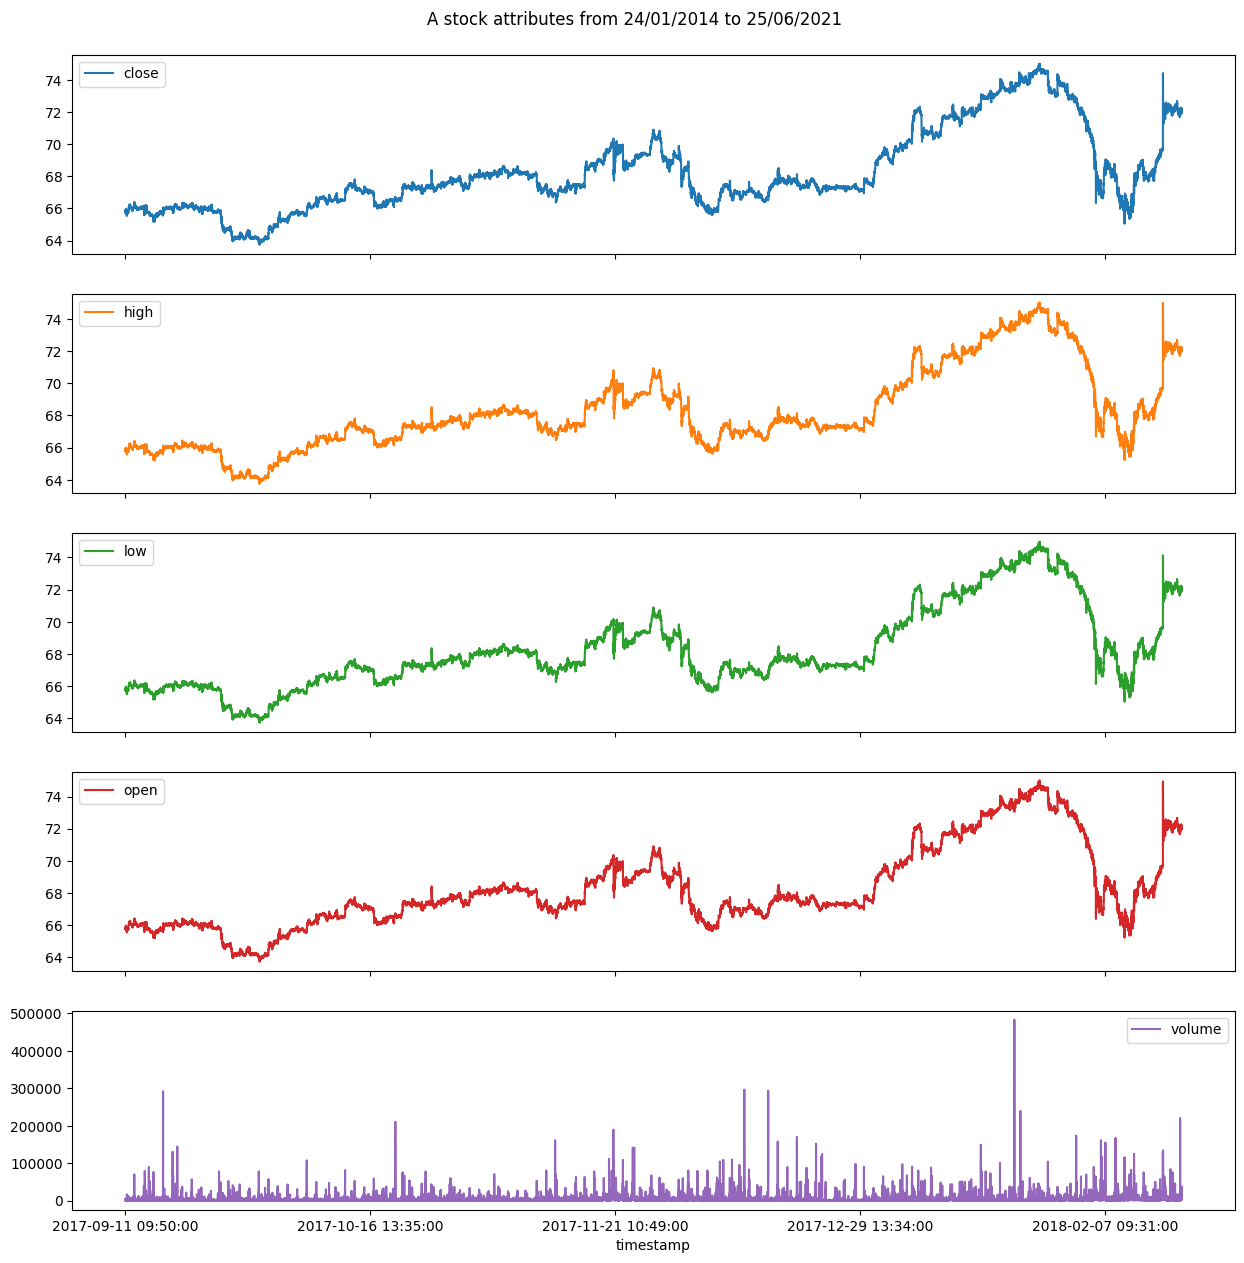

In [25]:
# Stock symbol 'A' behaviour
df1.plot(subplots=True, figsize=(15, 15))
plt.suptitle('A stock attributes from 24/01/2014 to 25/06/2021', y=0.91)
plt.show()

In [26]:
# Split train from  11/09/2017 9:30 A.M. to 17/01/2018 11:50 A.M and test data  from 17/01/2018 11:51A.M. to 16/02/2018 03:59A.M
train = df1.loc['2017-11-12 09:30:00':'2018-01-30 11:50:00']
test = df1.loc['2018-01-30 11:51:00':'2018-02-16 03:59:00']
train.shape

(20219, 5)

#### Data processing

In [27]:
# Standardize the data

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# Create a function to create sequences of data

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Create sequences with a length of 10
seq_length = 11
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

# Create data loaders
train_data = TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).float())
test_data = TensorDataset(torch.tensor(X_test).float(), torch.from_numpy(y_test).float())

batch_size = 64
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)


### Implementation model

In [8]:
from torch import nn

class VanillaLSTM(nn.Module):
    def __init__(self, num_feature):
        super(VanillaLSTM, self).__init__()
        self.lstm  = nn.LSTM(num_feature,64,batch_first=True)
        self.fc    = nn.Linear(64,num_feature)
        
    def forward(self, x):
        output, (hidden, cell) = self.lstm(x)
        x = self.fc(hidden)
        return x

model = VanillaLSTM(5)

In [9]:
# Optiemizer and rmse loss function
import torch.optim as optim

class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

criterion = RMSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

##### Model Training 
Define the forward and backward pass for training the neural network:

In [6]:
def train(dataloader):
    epoch_loss = 0
    model.train()  
    
    for batch in dataloader:
        optimizer.zero_grad()          
        x,y = batch
        pred = model(x)
        loss = criterion(pred[0],y)        
        loss.backward()               
        optimizer.step()      
        epoch_loss += loss.item()  
        
    return epoch_loss

Define only the forward pass for evaluating the model performance:

In [7]:
def evaluate(dataloader):
    epoch_loss = 0
    model.eval()  
    
    with torch.no_grad():
      for batch in dataloader:   
          x,y= batch
          pred = model(x)
          loss = criterion(pred[0],y)              
          epoch_loss += loss.item()  
        
    return epoch_loss / len(dataloader)

### Training the model for 600 epochs

In [32]:
n_epochs = 600
best_valid_loss = float('inf')

for epoch in range(1, n_epochs + 1):
    train_loss = train(train_loader)
    valid_loss = evaluate(test_loader)
    
    # Save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model, './checkpoint/saved_weights.pt')

    if (epoch % 200 == 0):
        print(f'\tEpoch: {epoch} | ' + f'\tTrain Loss: {train_loss:.5f} | ' + f'\tVal Loss: {valid_loss:.5f}\n')

	Epoch: 200 | 	Train Loss: 52.72862 | 	Val Loss: 0.25486

	Epoch: 400 | 	Train Loss: 61.78096 | 	Val Loss: 0.24906

	Epoch: 600 | 	Train Loss: 61.26464 | 	Val Loss: 0.24647



In [33]:
model=torch.load('./checkpoint/saved_weights.pt')

/var/folders/m1/kw3tpwys1m5bzfrsgxqkn4140000gn/T/ipykernel_89103/1530574977.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model=torch.load('./checkpoint/saved_weights.

In [34]:
X_test = torch.tensor(X_test).float()

with torch.no_grad():
  y_test_pred = model(X_test)

y_test_pred = y_test_pred.numpy()[0]

In [35]:
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred, multioutput='raw_values'))
mse = mean_squared_error(y_test, y_test_pred, multioutput='raw_values')
mae = mean_absolute_error(y_test, y_test_pred, multioutput='raw_values')
r2 = r2_score(y_test, y_test_pred, multioutput='raw_values')
index = ['RMSE','MSE', 'MAE', 'R2 score']

results = pd.DataFrame([rmse, mse, mae, r2], index=index, columns=['close','high','low','open','volume'])
results

,close,high,low,open,volume
RMSE,0.050081,0.048878,0.045358,0.043628,0.683681
MSE,0.002508,0.002389,0.002057,0.001903,0.467420
MAE,0.024282,0.020335,0.020056,0.015043,0.266381
R2 score,0.997719,0.997812,0.998143,0.998270,0.246438


## Last training result
train = df1.loc['2017-11-12 09:30:00':'2018-01-30 11:50:00'] 

test = df1.loc['2018-01-30 11:51:00':'2018-02-16 03:59:00']

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>close</th>
      <th>high</th>
      <th>low</th>
      <th>open</th>
      <th>volume</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>RMSE</th>
      <td>0.045912</td>
      <td>0.043599</td>
      <td>0.044478</td>
      <td>0.040182</td>
      <td>0.671828</td>
    </tr>
    <tr>
      <th>MSE</th>
      <td>0.002108</td>
      <td>0.001901</td>
      <td>0.001978</td>
      <td>0.001615</td>
      <td>0.451353</td>
    </tr>
    <tr>
      <th>MAE</th>
      <td>0.024092</td>
      <td>0.018686</td>
      <td>0.021166</td>
      <td>0.014628</td>
      <td>0.253309</td>
    </tr>
    <tr>
      <th>R2 score</th>
      <td>0.998083</td>
      <td>0.998259</td>
      <td>0.998214</td>
      <td>0.998533</td>
      <td>0.272340</td>
    </tr>
  </tbody>
</table>
</div>

## Prediction for LSTM without IT

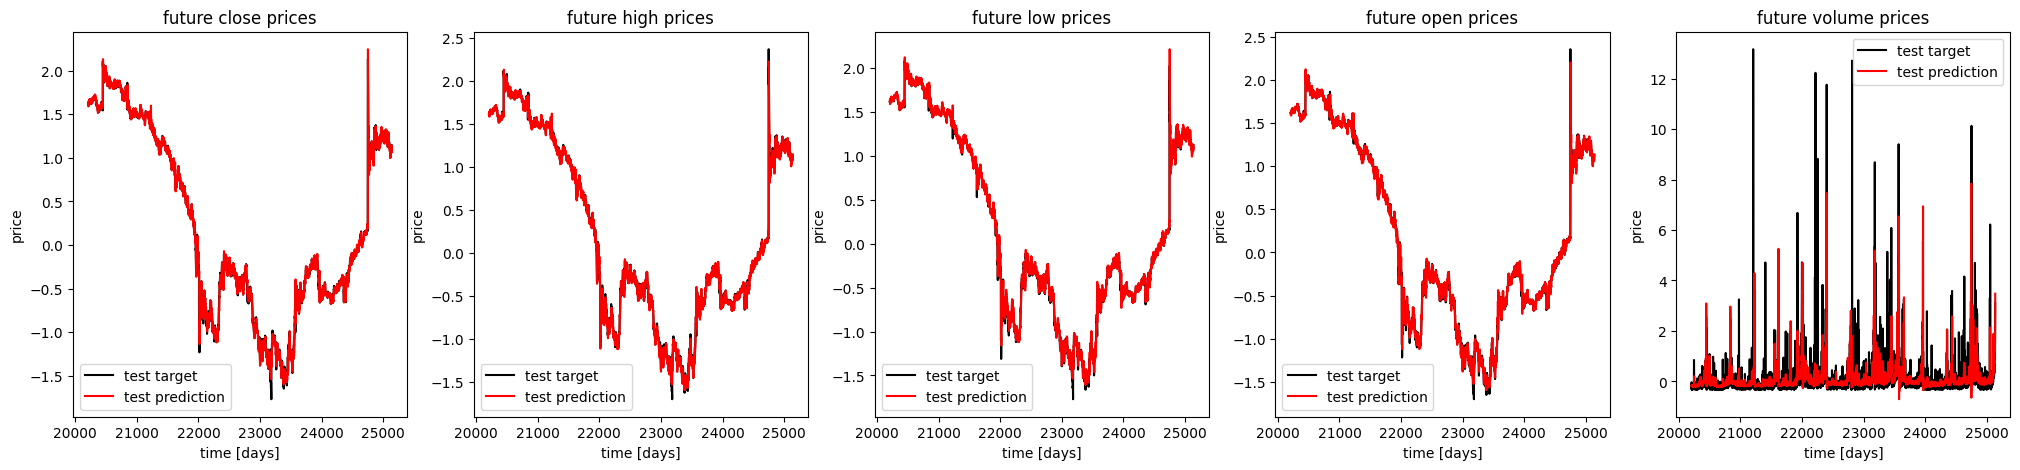

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=5)
fig.set_figwidth(25)
fig.set_figheight(5)
for i in range(5):
    ax[i].plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,i], color='black', label='test target')

    ax[i].plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,i], color='red', label='test prediction')

    ax[i].set_xlabel('time [days]')
    ax[i].set_ylabel('price')
    ax[i].legend(loc='best')

ax[0].set_title('future close prices')
ax[1].set_title('future high prices')
ax[2].set_title('future low prices')
ax[3].set_title('future open prices')
ax[4].set_title('future volume prices')

plt.show()

In [37]:
# Predicting the next 1 mins
seq_len = 11
sequences = []
for index in range(len(test) - seq_len + 1): 
    sequences.append(test[index: index + seq_len])
sequences = np.array(sequences)

last_sequence = sequences[-1:, 1:, :]
last_sequence = torch.from_numpy(last_sequence).float()

# Generate predictions
PREDICT = 10
with torch.no_grad():
    for i in range(PREDICT):
        pred_i = model(last_sequence)
        last_sequence = torch.cat((last_sequence, pred_i), dim=1)
        last_sequence = last_sequence[:, 1:, :]

pred_mins = last_sequence.squeeze(0).numpy()

# inverse transform the predicted values
pred_mins = scaler.inverse_transform(pred_mins)

df_pred = pd.DataFrame(
    data=pred_mins,
    columns=['<Open>', '<High>', '<Low>', '<Close>', '<Volume>']
)

print(df_pred)


# Calculate the RMSE for next 10 minutes predicted price change

y_test_pred = y_test_pred[:10]
y_test = y_test[:10]

rmse = np.sqrt(mean_squared_error(y_test, y_test_pred, multioutput='raw_values'))
mse = mean_squared_error(y_test, y_test_pred, multioutput='raw_values')
mae = mean_absolute_error(y_test, y_test_pred, multioutput='raw_values')
r2 = r2_score(y_test, y_test_pred, multioutput='raw_values')
index = ['RMSE','MSE', 'MAE', 'R2 score']

results = pd.DataFrame([rmse, mse, mae, r2], index=index, columns=['close','high','low','open','volume'])
print(results)
print('//////////////////////////////////////////')


# Calculate the RMSE for next 5 minutes predicted price change

y_test_pred = y_test_pred[:5]
y_test = y_test[:5]

rmse = np.sqrt(mean_squared_error(y_test, y_test_pred, multioutput='raw_values'))
mse = mean_squared_error(y_test, y_test_pred, multioutput='raw_values')
mae = mean_absolute_error(y_test, y_test_pred, multioutput='raw_values')
r2 = r2_score(y_test, y_test_pred, multioutput='raw_values')
index = ['RMSE','MSE', 'MAE', 'R2 score']

results = pd.DataFrame([rmse, mse, mae, r2], index=index, columns=['close','high','low','open','volume'])
print(results)
print('//////////////////////////////////////////')



      <Open>     <High>      <Low>    <Close>       <Volume>
0  68.784027  68.973061  68.921715  69.130028   71743.062500
1  68.302094  68.559280  68.263939  68.737839  116745.742188
2  68.626244  69.010292  68.509514  69.068024  140177.250000
3  68.883049  69.273094  68.755608  69.328102  149429.312500
4  68.909393  69.304436  68.781769  69.359901  150657.015625
5  68.912437  69.307632  68.785507  69.364006  150900.359375
6  68.912323  69.307465  68.785667  69.364128  150954.671875
7  68.911736  69.307037  68.784988  69.363617  150937.562500
8  68.912376  69.308914  68.784210  69.364235  150705.937500
9  68.922264  69.326187  68.785233  69.373703  149277.609375
             close      high       low      open    volume
RMSE      0.015041  0.015653  0.012223  0.011365  0.106596
MSE       0.000226  0.000245  0.000149  0.000129  0.011363
MAE       0.010685  0.011560  0.009165  0.009708  0.089280
R2 score -1.104327 -0.785873  0.155341  0.077098 -0.406150
//////////////////////////////////

## 10 Feature and technical indicator

In [49]:
# Add EMA12, EMA25, MACD, Boillinger Up and Boillinger Down to df2 dataframe
df2 = df_features.loc[:, 'A']
df2 = df2.iloc[:, :5]
df2['EMA12'] = df2['close'].ewm(span=12, adjust=False).mean()
df2['EMA26'] = df2['close'].ewm(span=26, adjust=False).mean()
df2['MACD'] = df2['EMA12'] - df2['EMA26']
df2['Boillinger Up'] = df2['close'].rolling(window=20).mean() + 2*df2['close'].rolling(window=20).std()
df2['Boillinger Down'] = df2['close'].rolling(window=20).mean() - 2*df2['close'].rolling(window=20).std()
df2

,close,high,low,open,volume,EMA12,EMA26,MACD,Boillinger Up,Boillinger Down
timestamp,,,,,,,,,,
2017-09-11 09:50:00,65.800,65.820,65.790,65.8124,2452.0,65.800000,65.800000,0.000000,NaN,NaN
2017-09-11 09:51:00,65.810,65.830,65.810,65.8200,2201.0,65.801538,65.800741,0.000798,NaN,NaN
2017-09-11 09:52:00,65.850,65.850,65.820,65.8200,1100.0,65.808994,65.804390,0.004605,NaN,NaN
2017-09-11 09:53:00,65.750,65.820,65.750,65.8200,4955.0,65.799918,65.800361,-0.000443,NaN,NaN
2017-09-11 09:54:00,65.765,65.765,65.765,65.7650,700.0,65.794546,65.797741,-0.003195,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2018-02-16 15:55:00,72.125,72.130,72.090,72.0950,17309.0,72.110174,72.110414,-0.000240,72.196076,71.984924
2018-02-16 15:56:00,72.070,72.125,72.070,72.1250,15441.0,72.103994,72.107421,-0.003427,72.196076,71.984924
2018-02-16 15:57:00,72.060,72.100,72.050,72.0700,18096.0,72.097225,72.103908,-0.006683,72.193999,71.982001


In [50]:
train2 = df2.loc['2017-11-12 09:30:00':'2018-01-30 11:50:00']
test2 = df2.loc['2018-01-30 11:51:00':'2018-02-16 03:59:00']
# Standardize the data

scaler = StandardScaler()
train_scaled2 = scaler.fit_transform(train2)
test_scaled2 = scaler.transform(test2)

# Create a function to create sequences of data

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Create sequences with a length of 10
seq_length = 11
X_train2, y_train2 = create_sequences(train_scaled2, seq_length)
X_test2, y_test2 = create_sequences(test_scaled2, seq_length)

# Create data loaders
train_data2 = TensorDataset(torch.tensor(X_train2).float(), torch.tensor(y_train2).float())
test_data2 = TensorDataset(torch.tensor(X_test2).float(), torch.from_numpy(y_test2).float())

batch_size = 64
train_loader2 = DataLoader(train_data2, shuffle=True, batch_size=batch_size)
test_loader2 = DataLoader(test_data2, shuffle=False, batch_size=batch_size)

In [51]:
model = VanillaLSTM(10)

In [21]:
n_epochs = 600
best_valid_loss = float('inf')

for epoch in range(1, n_epochs + 1):
    train_loss = train(train_loader2)
    valid_loss = evaluate(test_loader2)
    
    # Save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model, './checkpoint/saved_weights2.pt')

    if (epoch % 200 == 0):
        print(f'\tEpoch: {epoch} | ' + f'\tTrain Loss: {train_loss:.5f} | ' + f'\tVal Loss: {valid_loss:.5f}\n')

	Epoch: 200 | 	Train Loss: 314.56841 | 	Val Loss: 1.05376

	Epoch: 400 | 	Train Loss: 314.62717 | 	Val Loss: 1.05376

	Epoch: 600 | 	Train Loss: 314.61082 | 	Val Loss: 1.05376



In [54]:
model=torch.load('./checkpoint/saved_weights2.pt')

## Prediction for LSTM with IT

In [55]:
X_test2 = torch.tensor(X_test2).float()

with torch.no_grad():
  y_test_pred2 = model(X_test2)
  
y_test_pred2 = y_test_pred2.numpy()[0]

rmse = np.sqrt(mean_squared_error(y_test2, y_test_pred2, multioutput='raw_values'))
mse = mean_squared_error(y_test2, y_test_pred2, multioutput='raw_values')
mae = mean_absolute_error(y_test2, y_test_pred2, multioutput='raw_values')
r2 = r2_score(y_test2, y_test_pred2, multioutput='raw_values')
index = ['RMSE','MSE', 'MAE', 'R2 score']

results = pd.DataFrame([rmse, mse, mae, r2], index=index, columns=['close','high','low','open','volume', 'EMA12', 'EMA26', 'MACD', 'Boillinger Up', 'Boillinger Down'])
results

C:\Users\LT MSI\AppData\Local\Temp\ipykernel_21896\1543444065.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test2 = torch.tensor(X_test2).float()


,close,high,low,open,volume,EMA12,EMA26,MACD,Boillinger Up,Boillinger Down
RMSE,1.070421,1.031157,1.081056,1.150806,0.809703,1.081314,1.085670,1.863987,1.063993,1.022607
MSE,1.145802,1.063284,1.168682,1.324354,0.655620,1.169240,1.178680,3.474448,1.132082,1.045725
MAE,0.937573,0.920093,0.929170,1.002524,0.315166,0.939140,0.891829,1.129734,0.875082,0.870758
R2 score,-0.042102,0.026253,-0.054877,-0.203397,-0.056972,-0.064653,-0.073048,0.014335,-0.065531,0.095052


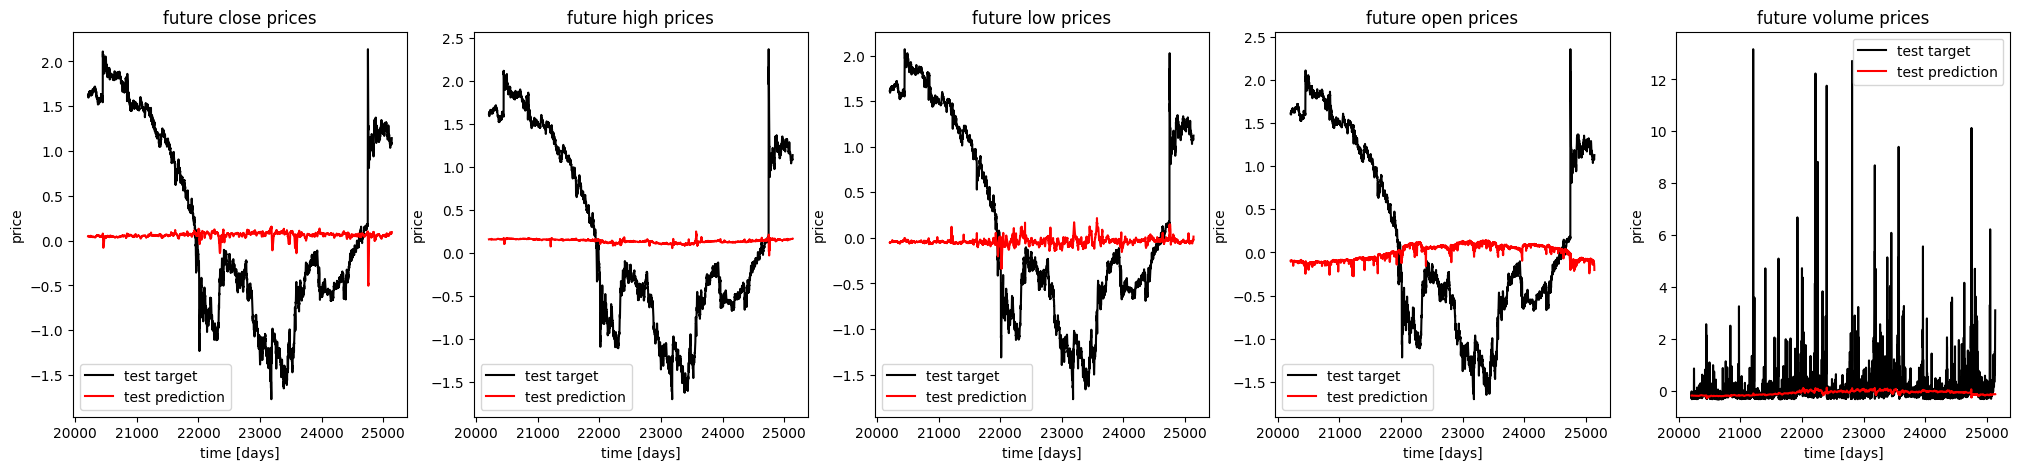

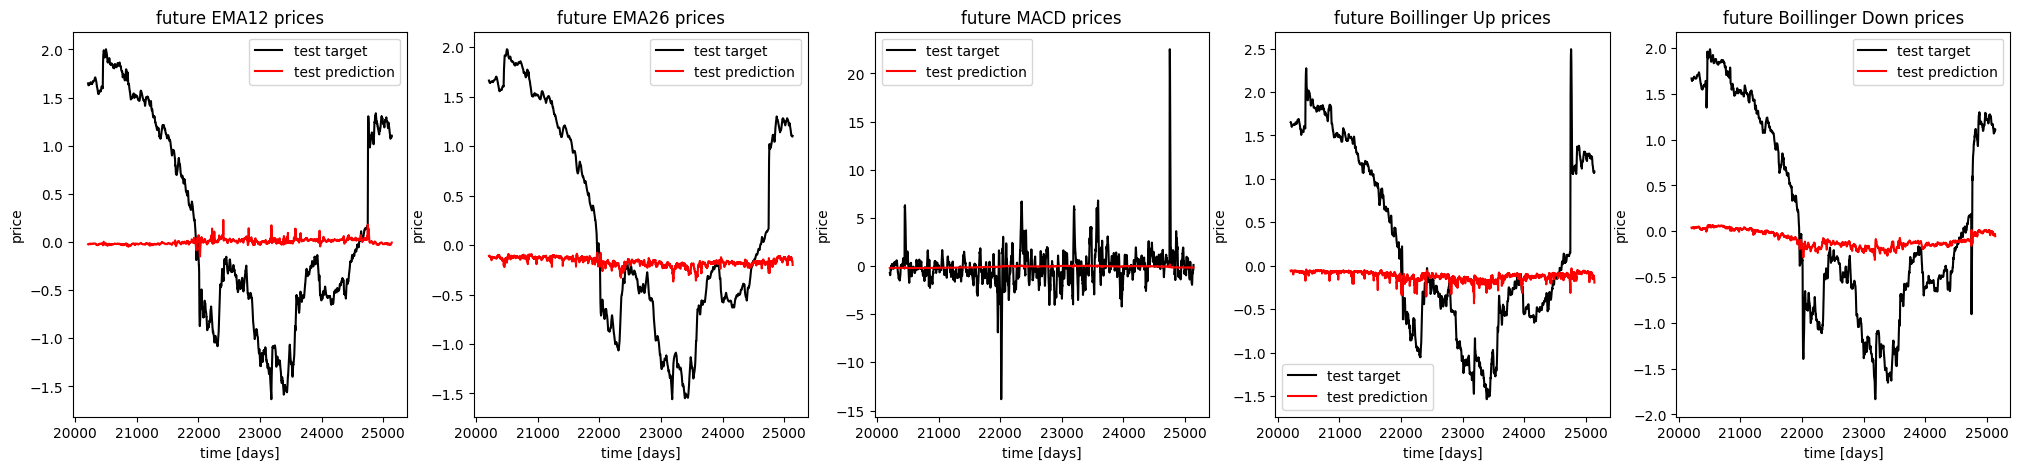

In [56]:
fig, ax = plt.subplots(nrows=1, ncols=5)
fig.set_figwidth(25)
fig.set_figheight(5)
for i in range(5):
    ax[i].plot(np.arange(y_train2.shape[0], y_train2.shape[0]+y_test2.shape[0]),
         y_test2[:,i], color='black', label='test target')

    ax[i].plot(np.arange(y_train2.shape[0], y_train2.shape[0]+y_test_pred2.shape[0]),
         y_test_pred2[:,i], color='red', label='test prediction')

    ax[i].set_xlabel('time [days]')
    ax[i].set_ylabel('price')
    ax[i].legend(loc='best')

ax[0].set_title('future close prices')
ax[1].set_title('future high prices')
ax[2].set_title('future low prices')
ax[3].set_title('future open prices')
ax[4].set_title('future volume prices')

# Show EMA12, EMA25, MACD, Boillinger Up and Boillinger Down base one the close price
fig, ax = plt.subplots(nrows=1, ncols=5)
fig.set_figwidth(25)
fig.set_figheight(5)

ax[0].plot(np.arange(y_train2.shape[0], y_train2.shape[0]+y_test2.shape[0]),
          y_test2[:,5], color='black', label='test target')

ax[0].plot(np.arange(y_train2.shape[0], y_train2.shape[0]+y_test_pred2.shape[0]),
          y_test_pred2[:,5], color='red', label='test prediction')

ax[0].set_xlabel('time [days]')
ax[0].set_ylabel('price')
ax[0].legend(loc='best')
ax[0].set_title('future EMA12 prices')

ax[1].plot(np.arange(y_train2.shape[0], y_train2.shape[0]+y_test2.shape[0]),
          y_test2[:,6], color='black', label='test target')

ax[1].plot(np.arange(y_train2.shape[0], y_train2.shape[0]+y_test_pred2.shape[0]),
          y_test_pred2[:,6], color='red', label='test prediction')

ax[1].set_xlabel('time [days]')
ax[1].set_ylabel('price')
ax[1].legend(loc='best')
ax[1].set_title('future EMA26 prices')

ax[2].plot(np.arange(y_train2.shape[0], y_train2.shape[0]+y_test2.shape[0]),
          y_test2[:,7], color='black', label='test target')  
ax[2].plot(np.arange(y_train2.shape[0], y_train2.shape[0]+y_test_pred2.shape[0]), 
          y_test_pred2[:,7], color='red', label='test prediction')
ax[2].set_xlabel('time [days]') 
ax[2].set_ylabel('price')
ax[2].legend(loc='best')
ax[2].set_title('future MACD prices')

ax[3].plot(np.arange(y_train2.shape[0], y_train2.shape[0]+y_test2.shape[0]),
          y_test2[:,8], color='black', label='test target')
ax[3].plot(np.arange(y_train2.shape[0], y_train2.shape[0]+y_test_pred2.shape[0]),
          y_test_pred2[:,8], color='red', label='test prediction')
ax[3].set_xlabel('time [days]')
ax[3].set_ylabel('price')
ax[3].legend(loc='best')
ax[3].set_title('future Boillinger Up prices')

ax[4].plot(np.arange(y_train2.shape[0], y_train2.shape[0]+y_test2.shape[0]),
          y_test2[:,9], color='black', label='test target')
ax[4].plot(np.arange(y_train2.shape[0], y_train2.shape[0]+y_test_pred2.shape[0]),  
          y_test_pred2[:,9], color='red', label='test prediction')
ax[4].set_xlabel('time [days]')
ax[4].set_ylabel('price') 
ax[4].legend(loc='best')
ax[4].set_title('future Boillinger Down prices')

plt.show()


In [57]:
# Predicting the next 10 mins
seq_len = 11
sequences = []
for index in range(len(y_test2) - seq_len + 1): 
    sequences.append(y_test2[index: index + seq_len])
sequences = np.array(sequences)

last_sequence = sequences[-1:, 1:, :]
last_sequence = torch.from_numpy(last_sequence).float()

# Generate predictions
PREDICT = 10
with torch.no_grad():
    for i in range(PREDICT):
        pred_i = model(last_sequence)
        last_sequence = torch.cat((last_sequence, pred_i), dim=1)
        last_sequence = last_sequence[:, 1:, :]

pred_mins = last_sequence.squeeze(0).numpy()

# inverse transform the predicted values
pred_mins = scaler.inverse_transform(pred_mins)

df_pred = pd.DataFrame(
    data=pred_mins,
    columns=['<Open>', '<High>', '<Low>', '<Close>', '<Volume>', '<EMA12>', '<EMA26>', '<MACD>', '<Boillinger Up>', '<Boillinger Down>']
)

df_pred

# Calculate the RMSE for next 10 minutes predicted price change

y_test_pred2 = y_test_pred2[:10]
y_test2 = y_test2[:10]

rmse = np.sqrt(mean_squared_error(y_test2, y_test_pred2, multioutput='raw_values'))
mse = mean_squared_error(y_test2, y_test_pred2, multioutput='raw_values')
mae = mean_absolute_error(y_test2, y_test_pred2, multioutput='raw_values')
r2 = r2_score(y_test2, y_test_pred2, multioutput='raw_values')
index = ['RMSE','MSE', 'MAE', 'R2 score']

results = pd.DataFrame([rmse, mse, mae, r2], index=index, columns=['close','high','low','open','volume', 'EMA12', 'EMA26', 'MACD', 'Boillinger Up', 'Boillinger Down'])
print(results)
print('//////////////////////////////////////////')

# Calculate the RMSE for next 5 minutes predicted price change

y_test_pred2 = y_test_pred2[:5]
y_test2 = y_test2[:5]

rmse = np.sqrt(mean_squared_error(y_test2, y_test_pred2, multioutput='raw_values'))
mse = mean_squared_error(y_test2, y_test_pred2, multioutput='raw_values')
mae = mean_absolute_error(y_test2, y_test_pred2, multioutput='raw_values')
r2 = r2_score(y_test2, y_test_pred2, multioutput='raw_values')
index = ['RMSE','MSE', 'MAE', 'R2 score']

results = pd.DataFrame([rmse, mse, mae, r2], index=index, columns=['close','high','low','open','volume', 'EMA12', 'EMA26', 'MACD', 'Boillinger Up', 'Boillinger Down'])


                 close          high           low          open    volume  \
RMSE          1.570416      1.456255      1.668300      1.715550  0.092836   
MSE           2.466206      2.120680      2.783224      2.943111  0.008619   
MAE           1.570380      1.456208      1.668248      1.715502  0.080412   
R2 score -22938.876325 -15456.405756 -15733.099769 -21027.149991 -0.066560   

                 EMA12         EMA26       MACD  Boillinger Up  \
RMSE          1.661461      1.763257   0.627381       1.706180   
MSE           2.760452      3.109075   0.393608       2.911052   
MAE           1.661449      1.763236   0.623578       1.706150   
R2 score -54175.536519 -72937.264689 -81.580025  -31307.200213   

          Boillinger Down  
RMSE             1.618358  
MSE              2.619083  
MAE              1.618342  
R2 score    -35711.808773  
//////////////////////////////////////////
